In [ ]:
import os, sys, logging, yaml, torch, random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))

from src.data.trajectory_manager import TrajectoryManager
from src.models.wMLP import weakFormMLP
from src.utils.checkpoint import load_checkpoint

logging.basicConfig(
    filename='test.log',  
    filemode='w',  
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
)    

config_path = 'config.yaml'
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

model_name = config['model']['name']
checkpoint_path = f'./nominal/{model_name}.pt'
# Check if the checkpoint exists, if so, load the metadata and override the yaml config
if os.path.exists(checkpoint_path) and config['training']['load_checkpoint']:
    logging.info(f"Checkpoint found at {checkpoint_path}, overriding the yaml config.")
    checkpoint = torch.load(checkpoint_path)
    metadata = checkpoint['metadata']
else:
    logging.info(f"No checkpoint found at {checkpoint_path}, using the yaml config.")
    metadata = {'config': config}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the TrajectoryManager
tm = TrajectoryManager(metadata, device=device)
_, datasets, data_meta = tm.process_all()
train_set,validation_set,test_set = datasets

# Initialize model and load trained weights
model = weakFormMLP(config['model'], data_meta).to(device)
if config['data']['double_precision']:
    model = model.double()
_ = load_checkpoint(model, _, _, checkpoint_path, load_from_checkpoint=True, inference_mode=True)

RMSE: 0.0012746316


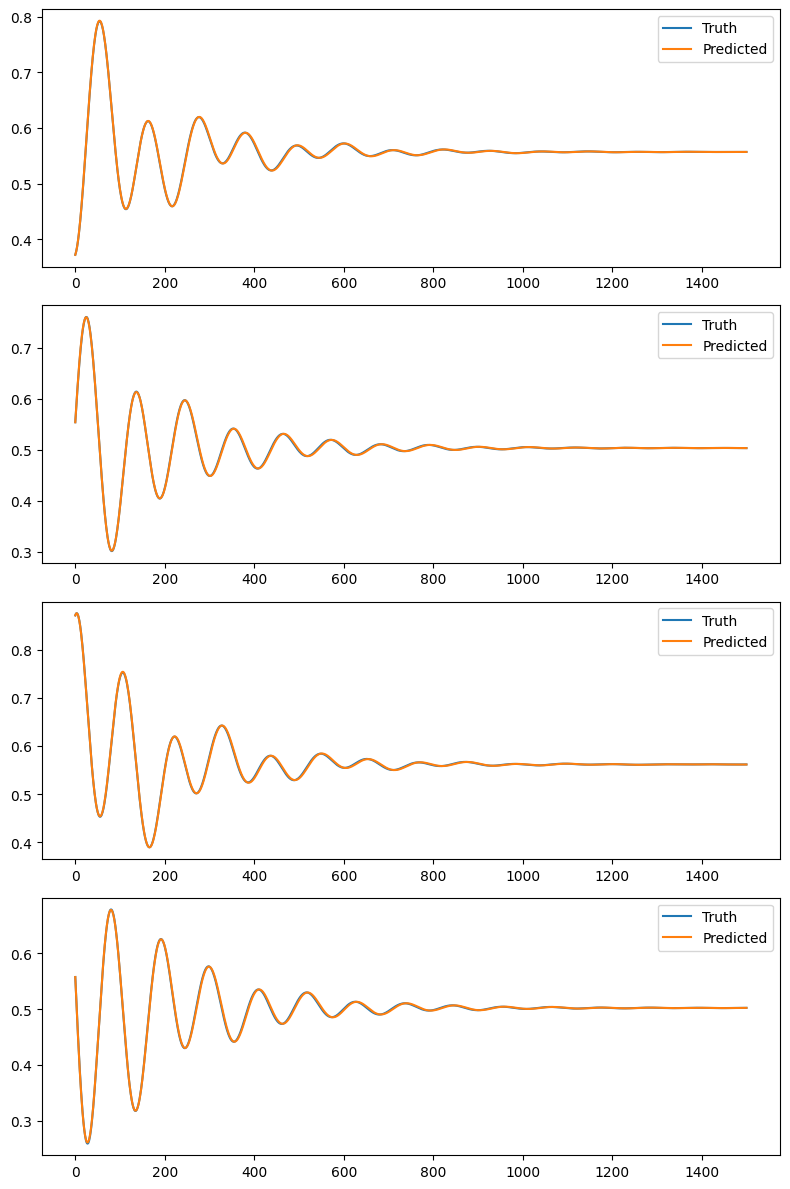

In [7]:
# Randomly pick a test trajectory
traj_train = random.choice(train_set)
traj_val = random.choice(validation_set)
traj_test = random.choice(test_set)

truth = traj_test
x_truth = truth[:, :data_meta['n_state_features']].detach().cpu().numpy()

x0, u0 = truth[0, :data_meta['n_state_features']], truth[0,-data_meta['n_control_features']:]
x_pred = model.predict(x0, u0, ts=tm.t[0]).detach().cpu().numpy()   

# Compute RMSE per dimension between predicted and true states
rmse = np.sqrt(np.mean((x_pred - x_truth)**2))
print("RMSE:", rmse)

# Create 4 subplots, one for each state dimension
fig, axes = plt.subplots(x_truth.shape[-1], 1, figsize=(8, 12))
for i in range(x_truth.shape[-1]):
    axes[i].plot(x_truth[:, i], label='Truth')
    axes[i].plot(x_pred[:, i], label='Predicted')
    axes[i].legend()
    
plt.tight_layout()
plt.show()